In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment3/'
# FOLDERNAME = 'CS348K Final Project/cs348k-project/'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# import os
# project_path = os.path.join('/content/drive/My Drive', FOLDERNAME)
# assert os.path.exists(project_path), "[!] The specified folder does not exist in Google Drive."


# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))



In [2]:
from sample import BaseModel, train_predictor, train_selector
from sample import PredictorNetwork
from sample import SelectorNetwork
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [3]:
"""Set up the DataLoaders: """
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transformation for the validation data
transform = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the validation dataset
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the full CIFAR-10 training dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the sizes for training and validation datasets (80/20 split)
train_size = 6400 #int(0.1 * len(full_train_dataset)) # 6400
val_size = len(full_train_dataset) - train_size

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define the DataLoader for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the CIFAR-10 test datase
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

test_size = int(0.1 * len(test_dataset))
_, small_test_dataset = random_split(test_dataset, [len(test_dataset) - test_size, test_size])

test_loader = DataLoader(small_test_dataset, batch_size=32, shuffle=False)

# Print the sizes of the datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(small_test_dataset)}')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 6400
Validation dataset size: 43600
Test dataset size: 1000


In [4]:
'''Instantiate models, criterion, and optimizer'''
# base_model = BaseModel()
base_model = BaseModel()
base_model.eval()
num_classes = 10 # CIFAR10

# Load the pretrained ResNet-50 model
resnet50 = models.resnet50(pretrained=True) # pretrained on ImageNet
# resnet50.eval() # sets this to evaluation mode

resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes) #rewrites resnet18 final fc layer




/Users/erik-luna/miniforge3/envs/cs221_hw7/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/erik-luna/miniforge3/envs/cs221_hw7/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/erik-luna/miniforge3/envs/cs221_hw7/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMA

In [5]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
'''Build the predictor/selector Database'''
import torch
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
from dataset_utils import PredictorDataset, SelectorDataset

output_shapes = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = resnet18.to(device)
resnet18.eval()

layer1_list, layer2_list, layer3_list, layer4_list, fc_list = [], [], [], [], []
binary_list = []


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_samples = 640  # Adjust this number as needed
indices = np.random.choice(len(val_dataset), num_samples, replace=False)
val_subset = Subset(val_dataset, indices)
val_subset_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

for images, labels in val_subset_loader: 
    out = images
    # print(out.shape)
    for name, layer in resnet18.named_children():
        if name == 'avgpool':
            out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        elif name == 'fc':
            out = out.view(out.size(0), -1)
            out = layer(out)
            fc_list.append(out.flatten())

            softmax_outputs = F.softmax(out, dim=1)
            _, preds = torch.max(softmax_outputs, 1)
            binary_list.extend((preds == labels).cpu().numpy())
        else:
            out = layer(out)
            if name == 'layer1':
                layer1_list.append(out.flatten())
            if name == 'layer2':
                layer2_list.append(out.flatten())
            if name == 'layer3':
                layer3_list.append(out.flatten())
            if name == 'layer4':
                layer4_list.append(out.flatten())
        output_shapes[name] = out.shape

predictor_layer1_dataset = PredictorDataset(layer1_list, fc_list)
predictor_layer2_dataset = PredictorDataset(layer2_list, fc_list)
predictor_layer3_dataset = PredictorDataset(layer3_list, fc_list)
predictor_layer4_dataset = PredictorDataset(layer4_list, fc_list)
selector_dataset = SelectorDataset(fc_list, binary_list)

# Create dataloaders
batch_size = 32
predictor_layer1_data_loader = DataLoader(predictor_layer1_dataset, batch_size=batch_size, shuffle=True)
predictor_layer2_data_loader = DataLoader(predictor_layer2_dataset, batch_size=batch_size, shuffle=True)
predictor_layer3_data_loader = DataLoader(predictor_layer3_dataset, batch_size=batch_size, shuffle=True)
predictor_layer4_data_loader = DataLoader(predictor_layer4_dataset, batch_size=batch_size, shuffle=True)
selector_data_loader = DataLoader(selector_dataset, batch_size=batch_size, shuffle=True)



Files already downloaded and verified


In [7]:
print(output_shapes['layer1'])
print(output_shapes['layer2'])
print(output_shapes['layer3'])
print(output_shapes['layer4'])
print(output_shapes['fc'])

torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])
torch.Size([32, 10])


In [10]:
from sample import PredictorNetwork, SelectorNetwork
from sample import BaseModel
# Example training function for predictor and selector networks
def train_predictor(model, dataloader, epochs=10):
    print("Training predictor")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    criterion = nn.MSELoss()
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)
    return loss_history

def train_selector(model, dataloader, epochs=10):
    print("Training selector")
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)
    return loss_history

layer1_flat = layer1_list[0].flatten()  #flat tensor
input_dim = layer1_flat.shape[0]  # This will be a tuple with a single element (total number of elements)
output_dim = 320 #### flatten w.r.t. each batch?

predictor_model = PredictorNetwork(input_dim, output_dim).to(device)
selector_model = SelectorNetwork(output_dim).to(device)

predictor_loss = train_predictor(predictor_model, predictor_layer1_data_loader)
selector_loss = train_selector(selector_model, selector_data_loader)


: 

In [9]:
print(input_dim)
print(output_dim)

6422528
10


In [ ]:
import torch

# Define your model class (example)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 2)

    def forward(self, x):
        return self.fc(x)

# Instantiate the model
model = MyModel()

# Specify the path where you want to save the model
p_save_path = 'models/p_layer1_v1.pth'
s_save_path = 'models/s_layer1_v1.pth'


# Save the model's state dictionary
torch.save(predictor_model.state_dict(), p_save_path)
torch.save(selector_model.state_dict(), s_save_path)

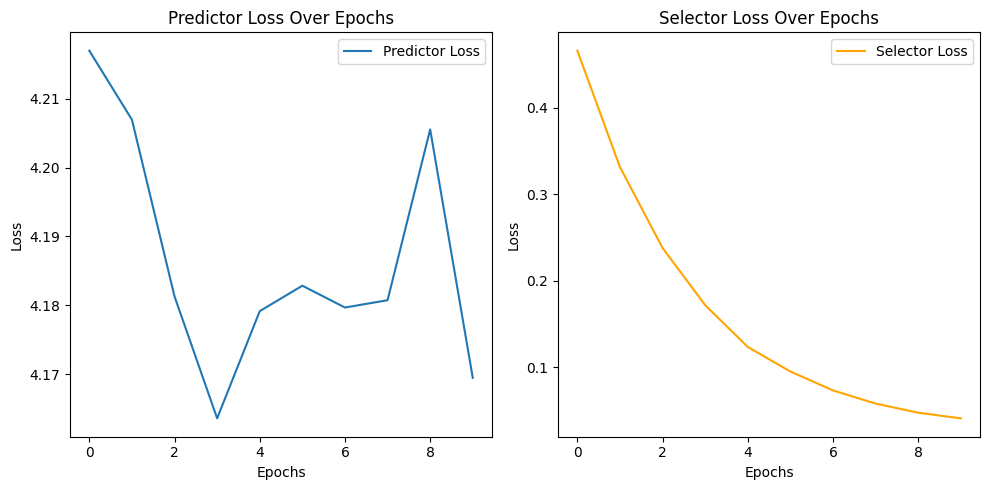

In [ ]:
import matplotlib.pyplot as plt
#Plotting the Loss: 
# Plotting the loss history
plt.figure(figsize=(10, 5))

# Plot predictor loss
plt.subplot(1, 2, 1)
plt.plot(predictor_loss, label='Predictor Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Predictor Loss Over Epochs')
plt.legend()

# Plot selector loss
plt.subplot(1, 2, 2)
plt.plot(selector_loss, label='Selector Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Selector Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
